# Variogram analysis and ordinary kriging for data in 2D (general)

Interpolate a data set in 2D, using ordinary kriging. Starting from a data set in 2D, the following is done:
- basic exploratory analysis: variogram cloud / variogram rose / experimental variogram
- fitting a covariance / variogram model, and cross-validation (LOO error)
- interpolation by ordinary kriging.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import grf
import geone.covModel as gcm
import geone.img as img
import geone.imgplot as imgplt
import geone.customcolors as ccol

## Preparation - build a data set in 2D

A data set in 2D is extracted from a Gaussian random field generated based on a known covariance model, called the *reference model* which will be considered as unknown further.

Define a (anisotropic) *reference* covariance model in 2D (class `covModel2D` from `geone.covModel`, see jupyter notebook `ex_grf_2d`).

In [2]:
cov_model_ref = gcm.CovModel2D(elem=[
    ('spherical', {'w':9.5, 'r':[90, 30]}),   # elementary contribution (different ranges: anisotropic)
    ('nugget', {'w':0.5})                     # elementary contribution
    ], alpha=-30.0, name='ref model (anisotropic)')

In [3]:
cov_model_ref

Covariance model 2D: (Name = ref model (anisotropic))
   2 elementary contribution(s)
   Elementary contribution 0: type : spherical
      parameters:  w = 9.5,  r = [90, 30]
   Elementary contribution 1: type : nugget
      parameters:  w = 0.5
   Angle: alpha = -30.0 deg.
   i.e.: the system Ox'y', supporting the axes of the model (ranges),
         is obtained from the system Oxy by applying a rotation of
         angle -alpha.

Generate a gaussian random field in 2D (see function `grf2D` from `geone.grf`), and extract data points:
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

In [4]:
# Simulation grid (domain)
nx, ny = 400, 420  # number of cells
dx, dy = 0.5, 0.5  # cell unit
ox, oy = 0.0, 0.0  # origin

# Reference simulation
np.random.seed(123)
ref = grf.grf2D(cov_model_ref, (nx, ny), (dx, dy), (ox, oy), nreal=1, printInfo=False) 
    # 3d-array of shape 1 x ny x nx

# Extract n points from the reference simulation
n = 120 # number of data points
ind = np.random.choice(nx*ny, size=n, replace=False) # indexes of extracted grid cells
ix = ind%nx  # indexes along x-axis
iy = ind//nx # indexes along y-axis
xc = ox + (ix + 0.5)*dx # x-coordinates of data points (centers of the extracted grid cells)
yc = oy + (iy + 0.5)*dy # y-coordinates of data points (centers of the extracted grid cells)
#xc = ox + (ind + np.random.random(n))*dx # x-coordinates of data points (within the extracted grid cells)
#yc = oy + (ind + np.random.random(n))*dy # y-coordinates of data points (within the extracted grid cells)

x = np.array((xc, yc)).T # array of coordinates of data points (shape: n x 2)
v = ref[0].reshape(-1)[ind] # value at data points

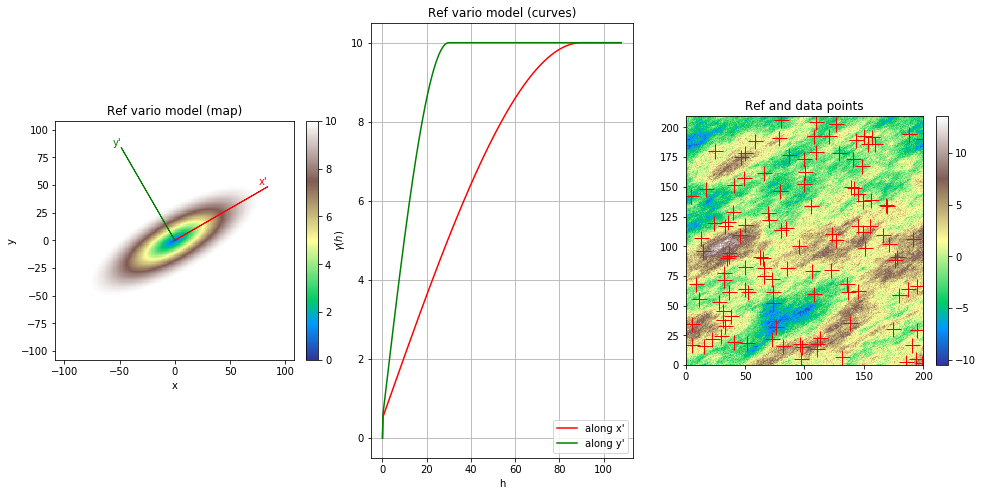

In [5]:
# Plot reference variogram model, reference simulation and data points
plt.subplots(1,3,figsize=(16,8))
plt.subplot(1,3,1)
cov_model_ref.plot_model(vario=True, plot_map=True, plot_curves=False)
plt.title('Ref vario model (map)')
plt.subplot(1,3,2)
cov_model_ref.plot_model(vario=True, plot_map=False, plot_curves=True)
plt.title('Ref vario model (curves)')
plt.subplot(1,3,3)
im_ref = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=1, val=ref) # fill image (Img class from geone.img) for view
imgplt.drawImage2D(im_ref, cmap='terrain')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.title('Ref and data points')
plt.show()

## Start from a data set in 2D
- `n`: number of data points, 
- `x`: location of data points (2-dimensional array of shape `(n, 2)`, each row is a point),
- `v`: values at data points (1-dimensional array of length `n`).

Visualise the data set and the histogram of values.

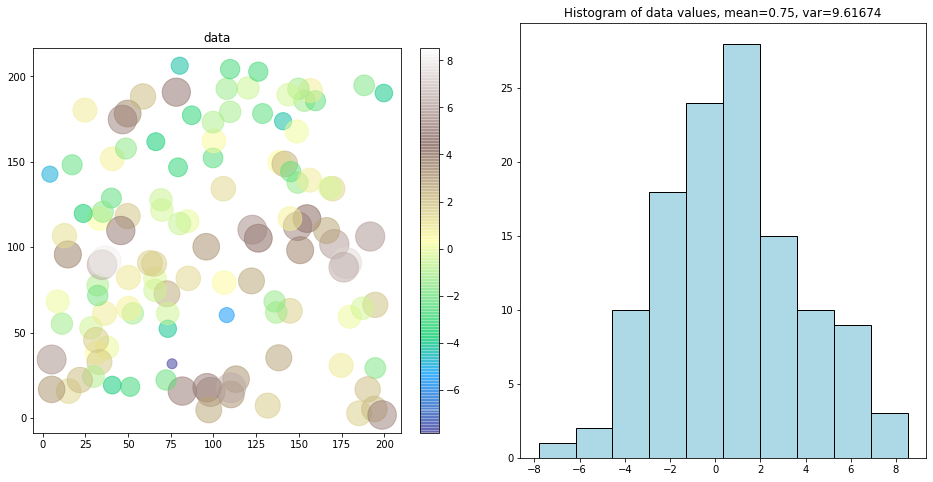

In [6]:
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
vmin, vmax = np.min(v), np.max(v) # min and max of data values
smin, smax = 100, 1000            # min and max size of points on plot
plot = plt.scatter(x[:,0], x[:,1], c=v, s=smin+(v-vmin)/(vmax-vmin)*(smax-smin), alpha=0.5, cmap='terrain')
ccol.add_colorbar(plot)
plt.axis('equal')
plt.title('data')

plt.subplot(1,2,2)
plt.hist(v, color='lightblue', edgecolor='black')
plt.title('Histogram of data values, mean={:.2g}, var={:2g}'.format(np.mean(v), np.var(v)))
plt.show()

### Variogram rose

The function `variogramExp2D_rose` shows an experimental variogram for a data set in 2D in the form of a rose plot, *i.e.* the lags vectors between the pairs of data points are divided in classes according to length (radius) and angle from the x-axis counter-clockwise (*warning:* opposite sense to the sense given by angle in definition of a covariance model in 2D).

The keyword argument `r_max` allows to specify a maximal length of 2D-lag vector between a pair of data points for being integrated in the variogram rose plot. The number of classes for radius (length) can be specified by the keyword argument `r_ncla`, and the number of classes for angle for half of the whole disk (rose plot is symmetric with respect to the origin) can be specified by the keyword argument `phi_ncla`.

This function can be useful to check a possible anisotropy.

Mean of empty slice.
invalid value encountered in double_scalars


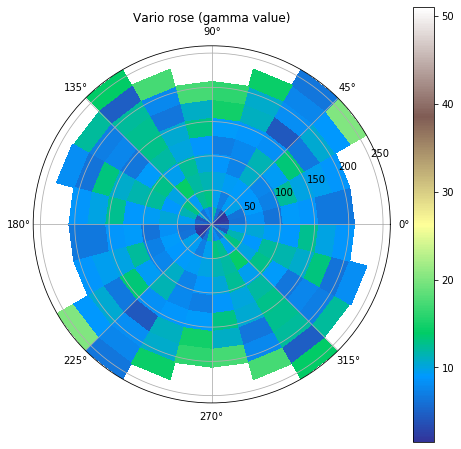

In [7]:
gcm.variogramExp2D_rose(x, v, figsize=(8,8))
plt.show()

For plotting a variogram rose in a multiple axes figure, proceed as follows.

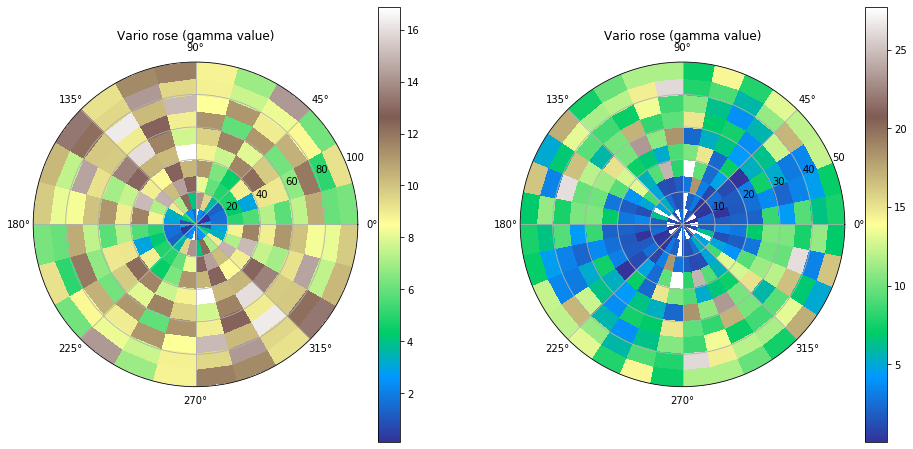

In [8]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(1,2,1, projection='polar')
gcm.variogramExp2D_rose(x, v, r_max=100, set_polar_subplot=False)

ax = fig.add_subplot(1,2,2, projection='polar')
gcm.variogramExp2D_rose(x, v, r_max=50, phi_ncla=16, set_polar_subplot=False)

plt.show()

One can observe a larger range for angles between $1/4\cdot45$ and $3/4\cdot45$ degrees (consistent with the reference covariance model used (but ignored here) where alpha is set to -30. Hence an anisotropic covariance / variogram model should be used.

**Note:** if no anisotropy is detected, one can continue with omni-directional analysis (see jupyter notebook `ex_vario_analysis_data2D_1_omnidirectional`).

### Model fitting
The function `covModel2D_fit` is used to fit a covariance model in 2D (class `covModel2D`).

This function takes as first argument the location of the data points, as second argument the values at the data points, and at third argument a covariance model in 2D with given type of elementary contributions and with parameters to fit set to `nan`. It returns the optimal covariance model and the vector of optimal parameters.

This function is based on the function `curve_fit` from `scipy.optimize` module. It fits the curve of the variogram model to the points $(h, \gamma(h))$, where $h$ is the lag between a pair of data points and $\gamma(h)$ is the half of the square of the difference of the values at these points. Hence, the fitting does not depend on the experimental variogram (see further), *i.e.* on the choice of direction or classes for the lags.

The function `covModel2D_fit` also takes the keyword argument `hmax`, which specifies the maximal distance between two data points to be integrated in the fitting. Note that a plot of the optimal model returned is made by default (keyword argument `make_plot=True`).

#### Bounds for parameters to fit
Bounds for parameters to fit can be specified to avoid meaningless optimal parameters returned (*e.g.* negative weight or range). Such bounds are given to the function `covModel2D_fit` (and then to the function `curve_fit` from `scipy.optimize`) via the keyword arguments `bounds=(<array of lower bounds>, <array of upper bounds>)`, where the arrays of lower / upper bounds have the same length as the vector of parameters to fit, with the $i-$th entry corresponding to the $i$-th parameter to fit (set to `nan`) in the covariance model passed as third argument. Note also that the keyword argument `p0` allows to specify a vector of initial parameters (see doc of function `curve_fit`).

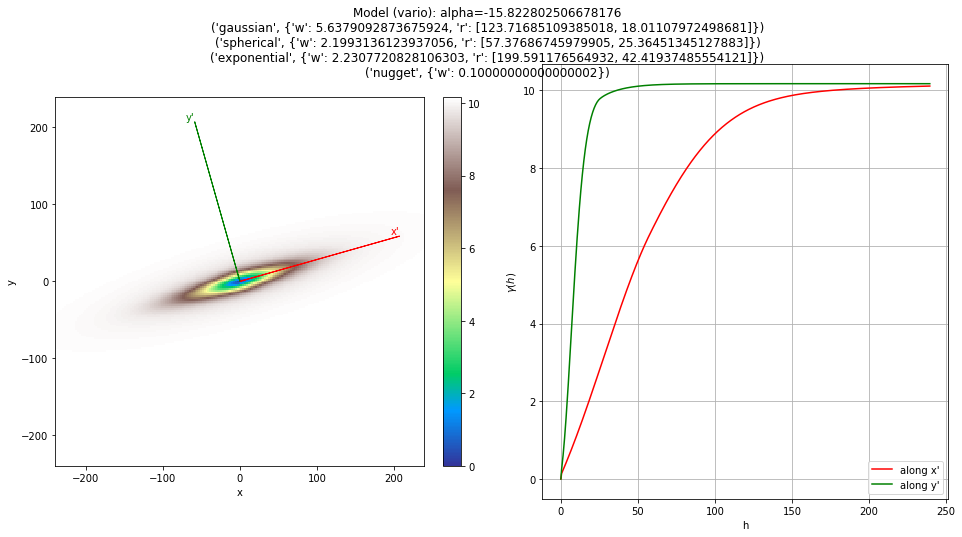

In [9]:
cov_model_to_optimize = gcm.CovModel2D(
    elem=[('gaussian',    {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
          ('nugget',      {'w':np.nan})                        # elementary contribution
         ], alpha=np.nan, name='')

cov_model_opt, popt = gcm.covModel2D_fit(x, v, cov_model_to_optimize, #hmax=150,
               bounds=([ 0,   0,   0,  0,   0,   0,  0,   0,   0,   .1,   -90],  # min value for param. to fit
                       [20, 200, 200, 20, 200, 200, 20, 200, 200,    2,    90]), # max value for param. to fit
                      # gaus. contr., sph. contr. , exp. contr. , nug., alpha
               make_plot=True, figsize=(16,8)) # figure size for plot
plt.show()

### Check with the experimental variograms in the main directions (derived from optimal angle retrieved)
The function `variogramExp2D` computes two directional exprimental variograms for a data set in 2D: one along each main axis ($x'$ and $y'$). The new system $Ox'y'$ is defined from the angle alpha (keyword argument `alpha`) in the same way as for covariance model in 2D.

The keyword arguments `tol_dist` and `tol_angle` allow to control which pair of data points are taken into account in the two experimental variograms: a pair of points $(x(i), x(j))$ is in the directional variogram cloud along axis $x'$ (resp. $y'$) iff, given the lag vector $h = x(i) - x(j)$:
- the distance from the end of vector $h$ issued from origin to that axis is less than or equal to `tol_dist` and,
- the angle between $h$ and that axis is less than or equal to `tol_angle`.

The maximal distance between two data points to be integrated can be specified by the keyword argument `hmax` (vector of two floats one for each axis), and the classes can be customized by using the keyword arguments `ncla`, `cla_center`, `cla_length` (each one is a vector of length 2, specification for each axis), in a similar way as explained for the function `variogramExp1D` (see jupyter notebook `ex_vario_analysis_data1D`).

The function `variogramExp2D` returns two experimental variograms "unidimensional" (see function `variogramExp1D` and jupyter notebook `ex_vario_analysis_data1D`).

**Note:** the function `variogramCloud2D` allows to compute variogram clouds along the main axes in a similar way.

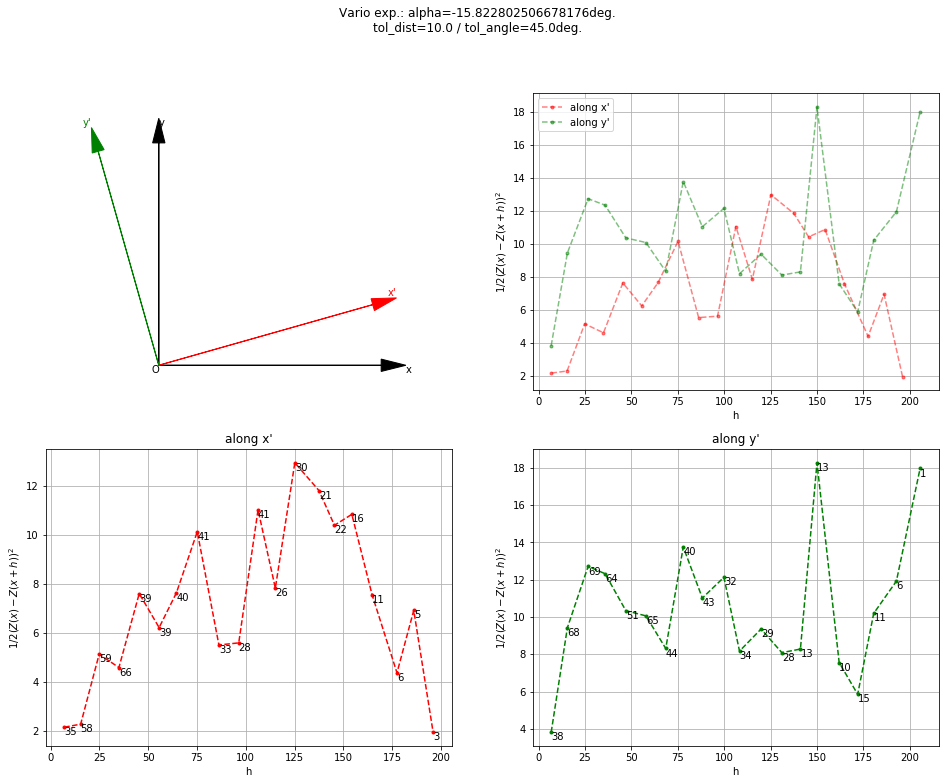

In [10]:
alpha_opt = popt[-1] # last component of popt
(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gcm.variogramExp2D(x, v, alpha=alpha_opt, ncla=(20,20), 
                                                                  make_plot=True, figsize=(16,12))

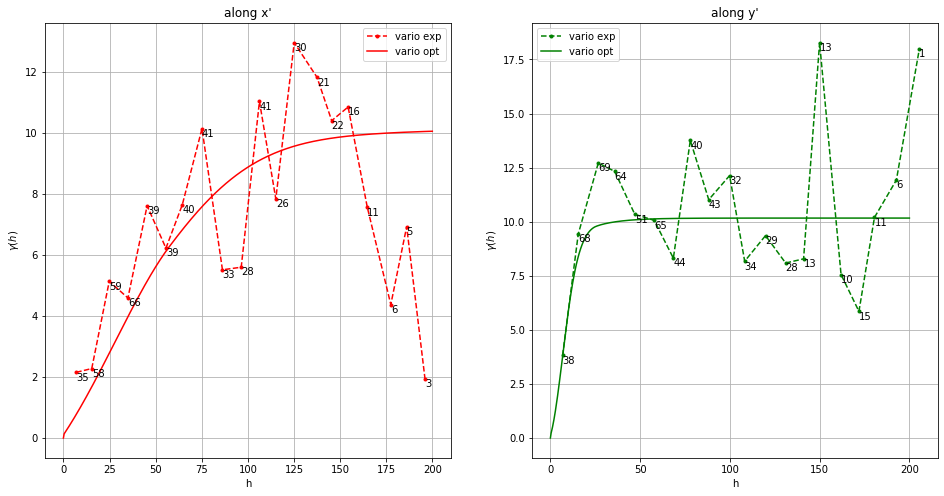

In [11]:
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
gcm.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=200, c='red', label='vario opt')
plt.legend()
plt.title("along x'")

plt.subplot(1,2,2)
gcm.plot_variogramExp1D(hexp2, gexp2, cexp2, c='green', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=200, c='green', label='vario opt')
plt.legend()
plt.title("along y'")

plt.show()

### Cross-validation of covariance model by leave-one-out error (based on ordinary kriging)
The function `cross_valid_loo_ok` makes a cross-validation test by leave-one-out (LOO) error. Here, a data set in 2D and a covariance model in 2D are given.

See jupyter notebook `ex_vario_analysis_data1D` for more details about this function.

Model does not pass test for sum of square of normalized error (chi2)!
   Sum of squares of normalized error = 164.4615443061184, above limit: 145.46074022476483


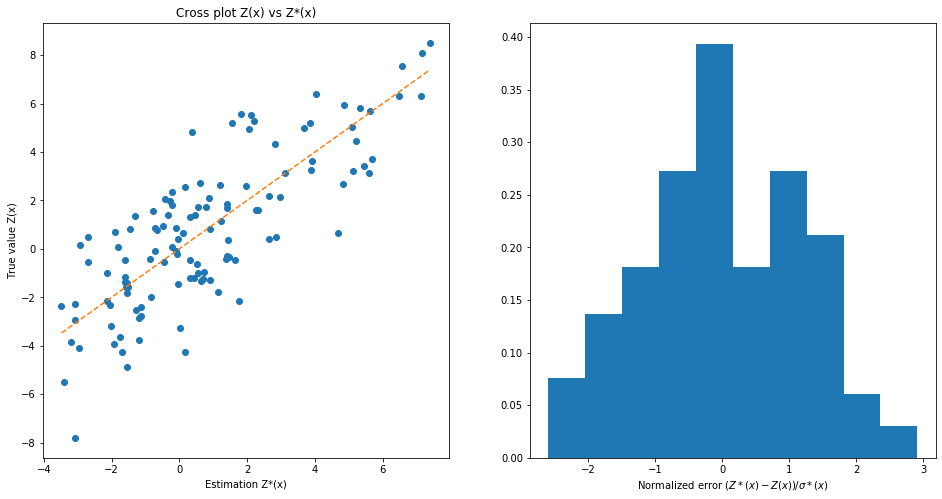

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: False


In [12]:
test_passed = gcm.cross_valid_loo_ok(x, v, cov_model_opt, make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(*test_passed))

The second test failed, then the covariance model should be rejected! Then, the search for a convenient covariance model continues.

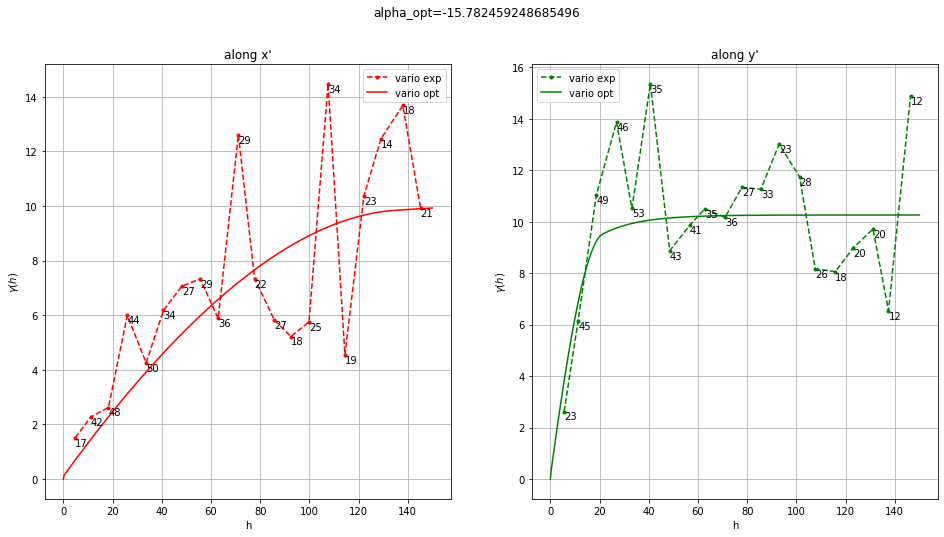

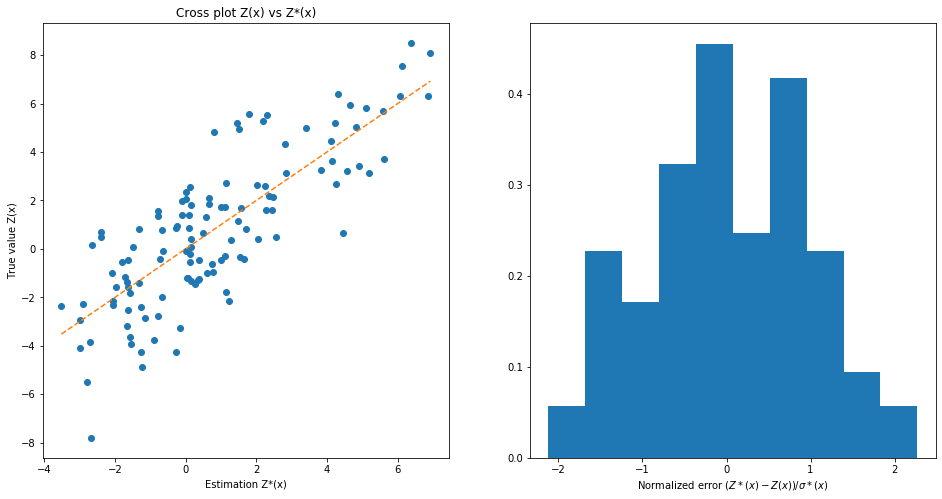

Test (1. normal law test for mean of normalized error) passed: True
Test (2. Chi2 test for sum of squares of normalized error) passed: True


Covariance model 2D: (Name = )
   4 elementary contribution(s)
   Elementary contribution 0: type : gaussian
      parameters:  w = 3.3995650163618564e-07,  r = [199.9930327915847, 12.317167221139679]
   Elementary contribution 1: type : spherical
      parameters:  w = 6.993838491450878,  r = [134.6508439812549, 21.14011746033656]
   Elementary contribution 2: type : exponential
      parameters:  w = 3.165223735113236,  r = [199.92855527507194, 43.9390179553066]
   Elementary contribution 3: type : nugget
      parameters:  w = 0.10000000000000002
   Angle: alpha = -15.782459248685496 deg.
   i.e.: the system Ox'y', supporting the axes of the model (ranges),
         is obtained from the system Oxy by applying a rotation of
         angle -alpha.

In [13]:
# Model fitting
cov_model_to_optimize = gcm.CovModel2D(
    elem=[('gaussian',    {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
          ('spherical',   {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
          ('exponential', {'w':np.nan, 'r':[np.nan, np.nan]}), # elementary contribution
          ('nugget',      {'w':np.nan})                        # elementary contribution
         ], alpha=np.nan, name='')

# New optim. while limiting the distance between pair of points to 150 (hmax=150)
hmax = 150
cov_model_opt, popt = gcm.covModel2D_fit(x, v, cov_model_to_optimize, hmax=hmax, 
               bounds=([ 0,   0,   0,  0,   0,   0,  0,   0,   0,   .1,   -90],  # min value for param. to fit
                       [20, 200, 200, 20, 200, 200, 20, 200, 200,    2,    90]), # max value for param. to fit
                      # gaus. contr., sph. contr. , exp. contr. , nug., alpha
               make_plot=False)

# Experimental variograms
alpha_opt = popt[-1] # last component of popt
(hexp1, gexp1, cexp1), (hexp2, gexp2, cexp2) = gcm.variogramExp2D(x, v, alpha=alpha_opt, hmax=(hmax, hmax), 
                                                                  ncla=(20,20), make_plot=False)

# Figure: optimal vario and exp. vario along main axes given by alpha_opt
plt.subplots(1,2,figsize=(16,8))
plt.subplot(1,2,1)
gcm.plot_variogramExp1D(hexp1, gexp1, cexp1, c='red', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=1, hmax=hmax, c='red', label='vario opt')
plt.legend()
plt.title("along x'")

plt.subplot(1,2,2)
gcm.plot_variogramExp1D(hexp2, gexp2, cexp2, c='green', label='vario exp')
cov_model_opt.plot_model_one_curve(vario=True, main_axis=2, hmax=hmax, c='green', label='vario opt')
plt.legend()
plt.title("along y'")

plt.suptitle('alpha_opt={}'.format(alpha_opt))
plt.show()

# Cross-validation
test_passed = gcm.cross_valid_loo_ok(x, v, cov_model_opt, make_plot=True, figsize=(16,8))
plt.show()
print('\
Test (1. normal law test for mean of normalized error) passed: {}\n\
Test (2. Chi2 test for sum of squares of normalized error) passed: {}'.format(*test_passed))
cov_model_opt

**Note:** the following illustrations are similar to what is done in the jupyter notebook `ex_vario_analysis_data2D_1_omnidirectional`).

### Data interpolation by ordinary kriging
The function `ordinary_kriging(x, v, xu, cov_model)` returns the kriging estimates and standard deviation at location `xu`, given the data points located at `x` with value `v` and the covariance model `cov_model`.

For data in 2D:
- `x`: 2-dimensional array of shape `(n, 2)`, location of data points (each row is a point),
- `v`: 1-dimensional array of length `n`, values at data points,
- `xu`: 2-dimensional array of shape `(m, 2)` location of points where the interpolation is done. 

In return:
- `vu`: 1-dimensional array of length `m`, (ordinary) kriging estimates at location `xu`,
- `vu_std`: 1-dimensional array of length `m`, (ordinary) kriging standard deviation at location `xu`.

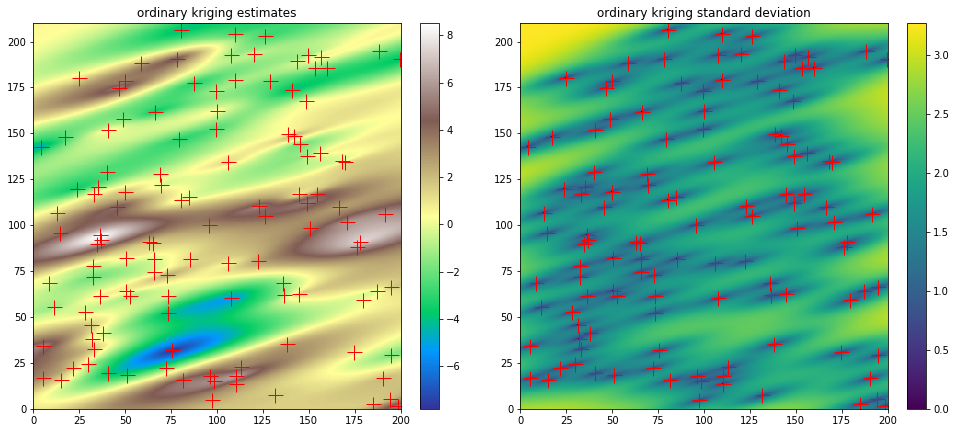

In [53]:
# Define points xu where to interpolate
# ... location of the 2D-grid used to build the data set (but it could be different)
xcu = ox + (np.arange(nx)+0.5)*dx # x-coordinates of points
ycu = oy + (np.arange(ny)+0.5)*dy # y-coordinates of points
xxcu, yycu = np.meshgrid(xcu, ycu)
xu = np.array((xxcu.reshape(-1), yycu.reshape(-1))).T # 2-dimensional array of shape nx*ny x 2

# Ordinary kriging
vu, vu_std = gcm.ordinary_kriging(x, v, xu, cov_model_opt)
# vu:     1-dimensional array, kriging estimates at location xu
# vu_std: 1-dimensional array, kriging standard deviation at location xu

# Fill image (Img class from geone.img) for view
#   variable 0: ordinary kriging estimates
#   variable 1: ordinary kriging standard deviation
im_ok = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu, vu_std)))

# Plot
plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
imgplt.drawImage2D(im_ok, iv=0, cmap='terrain', title='ordinary kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.subplot(1,2,2)
imgplt.drawImage2D(im_ok, iv=1, cmap='viridis', title='ordinary kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.show()

### Simple kriging (comparison)
Assuming the data (variable) stationary and specifying a constant mean (computed on the data set), the function `krige2D` (from `geone.grf` module, see jupyter notebook `ex_grf_2d`) can be used to compute simple krging estimates and standard deviation.

**Note:** a varying mean can also be specified.

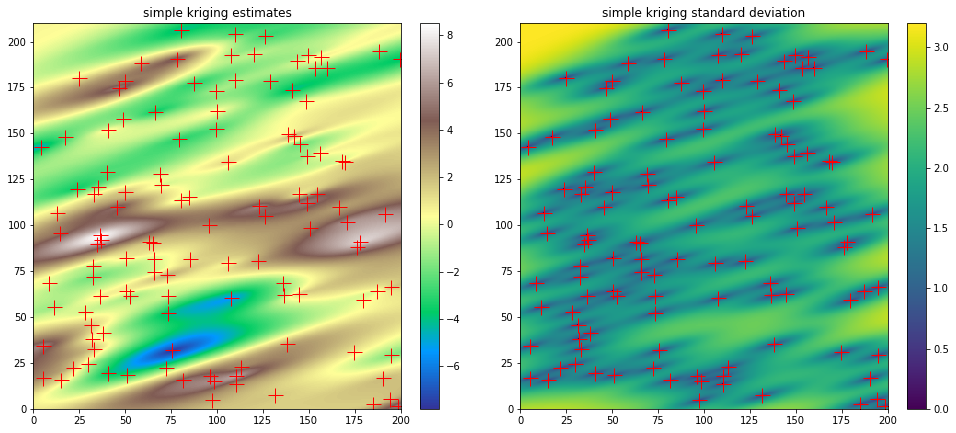

In [54]:
vu_sk, vu_sk_std = grf.krige2D(x, v, cov_model_opt, (nx, ny), (dx, dy), (ox, oy), 
                               mean=np.mean(v), printInfo=False)

# Fill image (Img class from geone.img) for view
#   variable 0: simple kriging estimates
#   variable 1: simple kriging standard deviation
im_sk = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=2, val=np.array((vu_sk, vu_sk_std)))

# Plot
plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
imgplt.drawImage2D(im_sk, iv=0, cmap='terrain', title='simple kriging estimates')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.subplot(1,2,2)
imgplt.drawImage2D(im_sk, iv=1, cmap='viridis', title='simple kriging standard deviation')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.show()

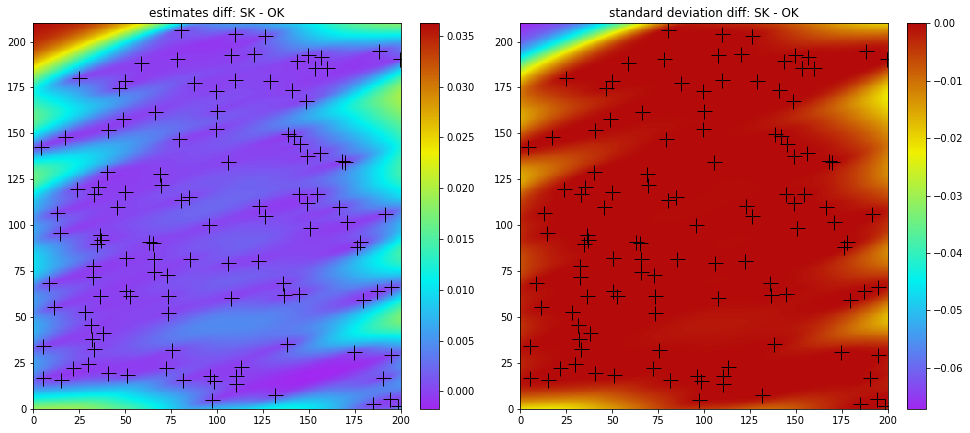

In [55]:
# Plot difference of simple kriging - ordinary kriging
im_diff = img.copyImg(im_sk)
im_diff.val = im_sk.val - im_ok.val

plt.subplots(1,2, figsize=(16,8))
plt.subplot(1,2,1)
imgplt.drawImage2D(im_diff, iv=0, title='estimates diff: SK - OK')
plt.plot(x[:,0], x[:,1], 'k+', markersize=15)
plt.subplot(1,2,2)
imgplt.drawImage2D(im_diff, iv=1, title='standard deviation diff: SK - OK')
plt.plot(x[:,0], x[:,1], 'k+', markersize=15)
plt.show()

### Conditional simulation using the function `grf2D`
Specifying the same mean, the function `grf2D` (from `geone.grf` module, see jupyter notebook `ex_grf_2d`) can be used to generate conditional realizations (based on simple kriging).

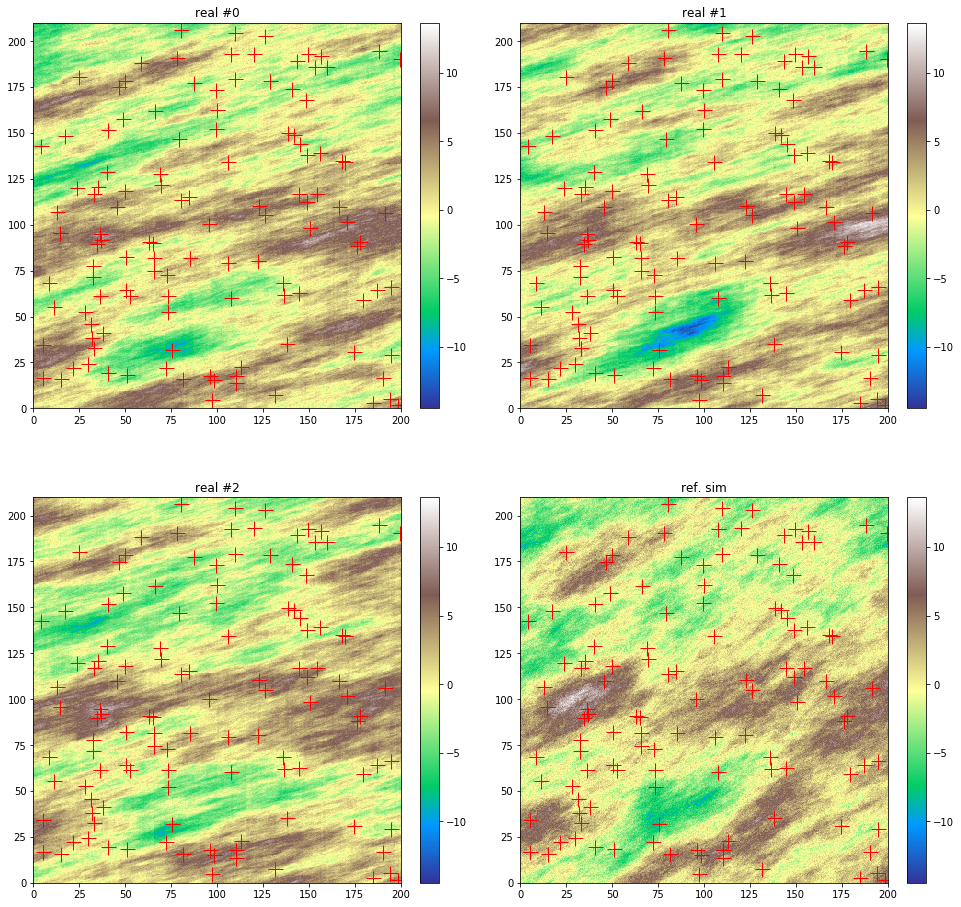

In [56]:
# Simulation
np.random.seed(293)
nreal = 3
sim = grf.grf2D(cov_model_opt, (nx, ny), (dx, dy), (ox, oy), 
                x=x, v=v, nreal=nreal, printInfo=False) # 3d-array of shape nreal x ny x nx

# Fill image (Img class from geone.img) for view
im_sim = img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=nreal, val=sim)

im_vmin = min(np.min(im_sim.vmin()), im_ref.vmin()[0]) # min over all real and ref. sim
im_vmax = max(np.max(im_sim.vmax()), im_ref.vmax()[0]) # max over all real and ref. sim

# Plot
plt.subplots(2,2, figsize=(16,16))
for i in range(3):
    plt.subplot(2,2,i+1)
    imgplt.drawImage2D(im_sim, iv=i, cmap='terrain', vmin=im_vmin, vmax=im_vmax, title='real #{}'.format(i))
    plt.plot(x[:,0], x[:,1], 'r+', markersize=15)

plt.subplot(2,2,4)
imgplt.drawImage2D(im_ref, cmap='terrain', vmin=im_vmin, vmax=im_vmax, title='ref. sim')
plt.plot(x[:,0], x[:,1], 'r+', markersize=15)
plt.show()

The retained optimal covariance model has an angle alpha of about -16, whereas for the reference covariance model (which is considered unknown!), alpha is -30. The ratio of ranges along the main axes is greater for the retained model than for the reference one, while the nugget is smaller. These difference are visible on the realizations above.